# Classification and Scoring analysis for Front End Engineering position

---

We'll define the model to train a resume classifier for **Front End** position.

First, a data set for training will be defined in this same repository. The training data consists in several data engineering job descriptions found through different job search platforms.

---
## 1. Data Preparation

---
#### 1.1 Helper Function Definitions

In [1]:
import spacy

nlp = spacy.load('en_core_web_md')
position = 'frontend'


# Some helper functions
def clean_text(text, lemma=False):
    # Tokenize
    doc = nlp(text)
    
    # Remove Stopwords
    tokens = [token for token in doc if not (token.is_stop or token.is_punct) ]
    
    # Lemmatisation
    if lemma == True:
        tokens = [token.lemma_.strip().lower()  for token in tokens if token.lemma_.strip()]
    else:
        tokens = [token.text.strip().lower() for token in tokens if token.text.strip()]
    
    return ' '.join(tokens)

def get_metrics(df):

    DE_TP = df[(df['predicted'] == df[position]) & (df['predicted'] == 1)]
    DE_TN = df[(df['predicted'] == df[position]) & (df['predicted'] == 0)]
    DE_FP = df[(df['predicted'] != df[position]) & (df['predicted'] == 1)]
    DE_FN = df[(df['predicted'] != df[position]) & (df['predicted'] == 0)]
    
    print(f'TP: {len(DE_TP)} TN: {len(DE_TN)} FP: {len(DE_FP)} FN: {len(DE_FN)}')
    accuracy = (len(DE_TP)+len(DE_TN)) / len(df)
    precision = len(DE_TP)/((len(DE_TP)+len(DE_FP)) if (len(DE_TP)+len(DE_FP)) > 0 else 1)
    recall = len(DE_TP)/(len(DE_TP)+len(DE_FN))
    f1 = 2*(precision*recall)/((precision+recall) if precision+recall > 0 else 1)
    
    
    return accuracy, precision, recall, f1


def test_real_resumes(model ,models):
    import os

    # Loading and preparing real Resumes data
    candidates_df = pd.read_csv(os.path.join(testing_files_dir, 'candidates.csv'))
    candidates_df = candidates_df.dropna()
    candidates_df.rename(columns={'data_engineer':'data_engineering'}, inplace=True)
    candidates_df = candidates_df[candidates_df[['data_engineering', 'frontend', 'sdet']].any(axis=1)]

    # Predicting for real Resumes
    candidates_df['predicted'] = models[model].predict(candidates_df['text'])
    candidates_df['predicted_probs'] = tuple(models[model].predict_proba(candidates_df['text']))

    # Taking out resumes with no specific real classification (for now)
    print('Metrics for [', position, '] using model: [', model, ']\n')
    # Calculate metrics
    accuracy, precision, recall, f1 = get_metrics(candidates_df)
    
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1}')
    
    return candidates_df


def compare_models(models):
    # Loading and preparing real Resumes data
    candidates_df = pd.read_csv(os.path.join(testing_files_dir, 'candidates.csv'))
    candidates_df = candidates_df.dropna()
    candidates_df.rename(columns={'data_engineer':'data_engineering'}, inplace=True)
    candidates_df = candidates_df[candidates_df[['data_engineering', 'frontend', 'sdet']].any(axis=1)]
    
    predictions = pd.DataFrame()
    predictions['metrics'] = ['accuracy', 'precision', 'recall', 'f1-score']
    predictions = predictions.set_index('metrics')
    for name, model in models.items():
        temp = candidates_df.copy()
        temp['predicted'] = model.predict(candidates_df['text'])
        temp['predicted_probs'] = tuple(model.predict_proba(candidates_df['text']))
        
        accuracy, precision, recall, f1 = get_metrics(temp)
        predictions[name] = [accuracy, precision, recall, f1]
    
    return predictions

---
#### 1.2 Data Load and Preprocessing

In [2]:
import pandas as pd
import os

# Defining the directories to use
training_files_dir = './training_data'
testing_files_dir = './data/testing'
training_file = position + '.csv'

valid_formats = ['txt', 'doc', 'docx', 'rtf', 'pdf']

# Loading the file containing the training info
df = pd.read_csv(os.path.join(training_files_dir, training_file))
print('Cleaning null registries...')
df.isna().sum()
print('Cleaning text for each registry...')
df['corpus'] = df['description'].apply(lambda x: clean_text(x,lemma=True))

Cleaning null registries...
Cleaning text for each registry...


---
#### 1.3 Datasets Preparation

In [3]:
from sklearn.model_selection import train_test_split

# Separating training and test data
y = df['tag'].values

df_train, df_test = train_test_split(df, test_size=0.25, random_state=1000)

y_train = df_train['tag']
y_test = df_test['tag']

---
#### 1.4 Vectorizer

Text(0.5, 1.0, 'Sparse Matrix Sample')

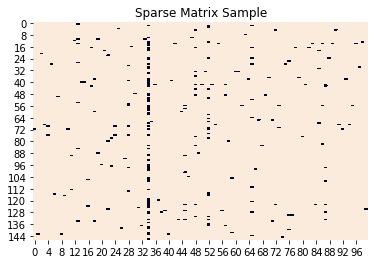

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np


corpus = df_train['corpus']
# BoW
vectorizer = CountVectorizer(ngram_range=(1,2))
# TD-IDF
#vectorizer = TfidfVectorizer(ngram_range=(1,2))

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)

sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

---
## 2. Models Analysis
---
#### 2.1 Logistic Regression Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

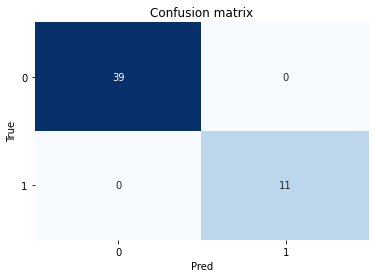

In [5]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import pipeline, preprocessing
from sklearn import metrics


models = {}

classifier = LogisticRegression()
model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', classifier)])
    
model['classifier'].fit(X_train, y_train)
models['LogisticRegression'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.2 SGDClassifier Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

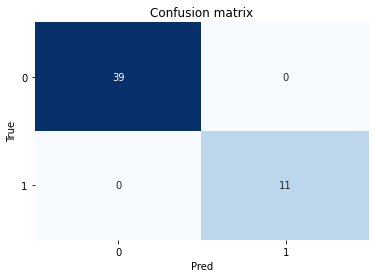

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV 


classifier = SGDClassifier()
classifier = classifier.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(classifier, cv='prefit')

model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', calibrator)])
    
model['classifier'].fit(X_train, y_train)
models['SGDClassifier'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.3 SVC Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

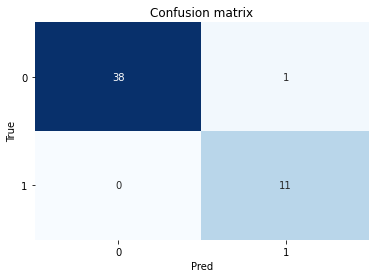

In [7]:
from sklearn.svm import SVC


classifier = SVC(probability=True)
model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', classifier)])
    
model['classifier'].fit(X_train, y_train)
models['SVC'] = model
    
X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.4 Naive Bayes

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

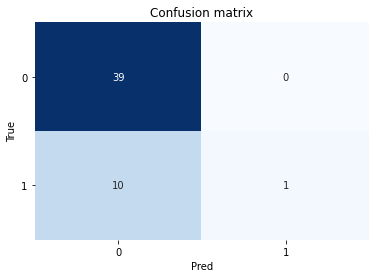

In [8]:
from sklearn import naive_bayes, pipeline, manifold, preprocessing

from sklearn import metrics
import matplotlib.pyplot as plt

classifier = naive_bayes.BernoulliNB()
model = pipeline.Pipeline([('vectorizer', vectorizer),
                           ('classifier', classifier)])

model['classifier'].fit(X_train, y_train)
models['NaiveBayes'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)


accuracy = metrics.accuracy_score(y_test.values, predicted)
auc = metrics.roc_auc_score(y_test.values, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.5 Comparing Metrics with Real Resumes

In [15]:
df = test_real_resumes('LogisticRegression', models)
df[df[position] == 1]

Metrics for [ frontend ] using model: [ LogisticRegression ]

TP: 37 TN: 16 FP: 1 FN: 9
Accuracy: 0.8412698412698413
Precision: 0.9736842105263158
Recall: 0.8043478260869565
F1-score: 0.8809523809523809


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,1,"(0.24640989572459437, 0.7535901042754056)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,0,"(0.9877689009846288, 0.012231099015371208)"
9,Alina_Diez,0,1,0,work experience software maintenance internshi...,1,"(0.006939276704060138, 0.9930607232959399)"
10,Arturo_Cordero,0,1,0,arturo cordero ingeniero en desarrollo de soft...,1,"(0.05964964980765253, 0.9403503501923475)"
11,Arturo_García_Fuentes,0,1,0,arturo garcía fuentes software developer perso...,1,"(0.04473336437337416, 0.9552666356266258)"
12,Arturo_Guerrero,0,1,0,arturo guerrero technology consultant en deloi...,1,"(0.10107003433084705, 0.898929965669153)"
13,Arturo_Sunallí_González_Hernández,0,1,0,arturo sunallí gonzález hernández software eng...,1,"(0.00036228600417809176, 0.9996377139958219)"
14,Axel_Caballero_Rivera,0,1,0,axel caballero rivera end engineer softtek sum...,1,"(2.5174812098294197e-06, 0.9999974825187902)"
15,Brenda_Scarleth_Gutierrez_Torres,0,1,0,curriculum vitae brenda scarleth gutiérrez tor...,0,"(0.6199366222139567, 0.38006337778604327)"
18,Cesar_Artemio_Rivera_Casanova,0,1,0,césar artemio rivera casanova developer addres...,1,"(0.03989604727330576, 0.9601039527266942)"


In [16]:
df = test_real_resumes('SGDClassifier', models)
df[df[position] == 1]

Metrics for [ frontend ] using model: [ SGDClassifier ]

TP: 38 TN: 16 FP: 1 FN: 8
Accuracy: 0.8571428571428571
Precision: 0.9743589743589743
Recall: 0.8260869565217391
F1-score: 0.8941176470588235


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,1,"(0.18805536710579773, 0.8119446328942023)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,0,"(0.979700432978856, 0.020299567021143983)"
9,Alina_Diez,0,1,0,work experience software maintenance internshi...,1,"(0.005434150492508394, 0.9945658495074916)"
10,Arturo_Cordero,0,1,0,arturo cordero ingeniero en desarrollo de soft...,1,"(0.007703627236976041, 0.992296372763024)"
11,Arturo_García_Fuentes,0,1,0,arturo garcía fuentes software developer perso...,1,"(0.13460929271948263, 0.8653907072805174)"
12,Arturo_Guerrero,0,1,0,arturo guerrero technology consultant en deloi...,1,"(0.0684857297415391, 0.9315142702584609)"
13,Arturo_Sunallí_González_Hernández,0,1,0,arturo sunallí gonzález hernández software eng...,1,"(0.0006635527015567133, 0.9993364472984433)"
14,Axel_Caballero_Rivera,0,1,0,axel caballero rivera end engineer softtek sum...,1,"(3.162279385682254e-05, 0.9999683772061432)"
15,Brenda_Scarleth_Gutierrez_Torres,0,1,0,curriculum vitae brenda scarleth gutiérrez tor...,0,"(0.5613962910211445, 0.4386037089788554)"
18,Cesar_Artemio_Rivera_Casanova,0,1,0,césar artemio rivera casanova developer addres...,1,"(0.12154335862439214, 0.8784566413756079)"


In [17]:
df = test_real_resumes('SVC', models)
df[df[position] == 1]

Metrics for [ frontend ] using model: [ SVC ]

TP: 25 TN: 16 FP: 1 FN: 21
Accuracy: 0.6507936507936508
Precision: 0.9615384615384616
Recall: 0.5434782608695652
F1-score: 0.6944444444444445


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,1,"(0.32815017460860824, 0.6718498253913917)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,0,"(0.9659595424859716, 0.03404045751402849)"
9,Alina_Diez,0,1,0,work experience software maintenance internshi...,1,"(0.009307058193302502, 0.9906929418066976)"
10,Arturo_Cordero,0,1,0,arturo cordero ingeniero en desarrollo de soft...,0,"(0.9819568953857106, 0.018043104614289436)"
11,Arturo_García_Fuentes,0,1,0,arturo garcía fuentes software developer perso...,1,"(0.026155638731595498, 0.9738443612684043)"
12,Arturo_Guerrero,0,1,0,arturo guerrero technology consultant en deloi...,1,"(0.16709595088675622, 0.832904049113244)"
13,Arturo_Sunallí_González_Hernández,0,1,0,arturo sunallí gonzález hernández software eng...,0,"(0.9346379749279566, 0.06536202507204346)"
14,Axel_Caballero_Rivera,0,1,0,axel caballero rivera end engineer softtek sum...,1,"(0.03327766168552895, 0.966722338314471)"
15,Brenda_Scarleth_Gutierrez_Torres,0,1,0,curriculum vitae brenda scarleth gutiérrez tor...,0,"(0.542660309521087, 0.457339690478913)"
18,Cesar_Artemio_Rivera_Casanova,0,1,0,césar artemio rivera casanova developer addres...,1,"(0.012419732114660572, 0.9875802678853396)"


In [18]:
df = test_real_resumes('NaiveBayes', models)
df[df[position] == 1]

Metrics for [ frontend ] using model: [ NaiveBayes ]

TP: 1 TN: 17 FP: 0 FN: 45
Accuracy: 0.2857142857142857
Precision: 1.0
Recall: 0.021739130434782608
F1-score: 0.042553191489361694


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,0,"(1.0, 2.8027973180781815e-52)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,0,"(1.0, 3.0914618714055903e-53)"
9,Alina_Diez,0,1,0,work experience software maintenance internshi...,0,"(1.0, 2.3012949222343377e-34)"
10,Arturo_Cordero,0,1,0,arturo cordero ingeniero en desarrollo de soft...,0,"(1.0, 1.1187564120135255e-31)"
11,Arturo_García_Fuentes,0,1,0,arturo garcía fuentes software developer perso...,0,"(1.0, 7.729275801369994e-48)"
12,Arturo_Guerrero,0,1,0,arturo guerrero technology consultant en deloi...,0,"(1.0, 1.3546183473174345e-53)"
13,Arturo_Sunallí_González_Hernández,0,1,0,arturo sunallí gonzález hernández software eng...,0,"(1.0, 1.4026701207515052e-30)"
14,Axel_Caballero_Rivera,0,1,0,axel caballero rivera end engineer softtek sum...,1,"(6.157527033522452e-15, 1.0)"
15,Brenda_Scarleth_Gutierrez_Torres,0,1,0,curriculum vitae brenda scarleth gutiérrez tor...,0,"(1.0, 3.513575824116539e-58)"
18,Cesar_Artemio_Rivera_Casanova,0,1,0,césar artemio rivera casanova developer addres...,0,"(1.0, 5.2895177615323726e-34)"


---
#### 2.6 Choosing the Model

In [13]:
compare_models(models)

TP: 37 TN: 16 FP: 1 FN: 9
TP: 38 TN: 16 FP: 1 FN: 8
TP: 25 TN: 16 FP: 1 FN: 21
TP: 1 TN: 17 FP: 0 FN: 45


,LogisticRegression,SGDClassifier,SVC,NaiveBayes
metrics,,,,
accuracy,0.841270,0.857143,0.650794,0.285714
precision,0.973684,0.974359,0.961538,1.000000
recall,0.804348,0.826087,0.543478,0.021739
f1-score,0.880952,0.894118,0.694444,0.042553


In [14]:
deploy_dir = '../app/models'
model_to_deploy = 'LogisticRegression'

pd.to_pickle(models[model_to_deploy], os.path.join(deploy_dir, '.'.join([position, 'pickle'])))